# Similarity, Neighbors, Clustering
# and...
# Whiskey Analytics!


Spring 2018 - Profs. Foster Provost and Josh Attenberg

Assistant Teacher : Nicholas  Garcia


In [1]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial import distance

%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = 10, 8


from dstools import data_tools

np.random.seed(36)

# Whiskey Analytics

**Given that I discover that I like one whiskey, how can I find another that I might like?**

Let's talk about that.....



-


-


-


-


-


-


-


-


-


-

# Data
Following that discussion (see Chapter 6 of *Data Science for Business*, if this wasn't interactive for you), we have compiled a scotch whiskey data set. You can find it in `data/scotch.csv`.

The data consists of 5 general whiskey attributes, each of which has many possible values:

- **Color**: yellow, very pale, pale, pale gold, gold, old gold, full gold, amber, etc.
- **Nose**: aromatic, peaty, sweet, light, fresh, dry, grassy, etc.
- **Body**: soft, medium, full, round, smooth, light, firm, oily.
- **Palate**: full, dry, sherry, big, fruity, grassy, smoky, salty, etc.
- **Finish**: full, dry, warm, light, smooth, clean, fruity, grassy, smoky, etc.

Let's read it in and take a look. There are a few other features unrelated to the ones above. For this class, we will be dropping them. However, feel free to check them out!

In [2]:
data = pd.read_csv("data/scotch.csv")

data = data.drop([u'age', u'dist', u'score', u'percent', u'region', u'district', u'islay', u'midland', u'spey', u'east', u'west', u'north ', u'lowland', u'campbell', u'islands'], axis=1)

In [3]:
data.head()

,color.wyne,color.yellow,color.v.pale,color.pale,color.p.gold,color.gold,color.o.gold,color.f.gold,color.bronze,color.p.amber,...,fin.smoke,fin.sweet,fin.spice,fin.oil,fin.salt,fin.arome,fin.ling,fin.long,fin.very,fin.quick
Aberfeldy,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Aberlour,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Ardberg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Ardmore,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Auchentoshan,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


# Similarity measures

Once we have objects described as data, we can compute the similarity between different objects.  As with most data analytics, the tried-and-true way to represent objects with data is to create a **feature vector** for each object.

Thus, each of our whiskeys now is described by its feature vector (68 attributes).

In [4]:
data_tools.feature_printer(data, 'Aberfeldy') 

"'color.yellow', 'nose.aroma', 'nose.peat', 'nose.fruit', 'body.soft', 'body.med', 'pal.sherry', 'pal.oil', 'fin.full', 'fin.dry', 'fin.fruit', 'fin.spice'"

In [5]:
data.loc['Aberfeldy']

color.wyne       0
color.yellow     1
color.v.pale     0
color.pale       0
color.p.gold     0
color.gold       0
color.o.gold     0
color.f.gold     0
color.bronze     0
color.p.amber    0
color.amber      0
color.f.amber    0
color.red        0
color.sherry     0
nose.aroma       1
nose.peat        1
nose.sweet       0
nose.light       0
nose.fresh       0
nose.dry         0
nose.fruit       1
nose.grass       0
nose.sea         0
nose.sherry      0
nose.spicy       0
nose.rich        0
body.soft        1
body.med         1
body.full        0
body.round       0
                ..
pal.light        0
pal.smooth       0
pal.clean        0
pal.fruit        0
pal.grass        0
pal.smoke        0
pal.sweet        0
pal.spice        0
pal.oil          1
pal.salt         0
pal.arome        0
fin.full         1
fin.dry          1
fin.warm         0
fin.big          0
fin.light        0
fin.smooth       0
fin.clean        0
fin.fruit        1
fin.grass        0
fin.smoke        0
fin.sweet   

We can see any other whiskey and its vector, including Foster's favorite, "Bunnahabhain".

In [6]:
print ( data_tools.feature_printer(data, 'Bunnahabhain') )

'color.gold', 'nose.fresh', 'nose.sea', 'body.med', 'body.light', 'body.firm', 'pal.clean', 'pal.fruit', 'pal.sweet', 'fin.full'


So ... Foster would like to know: What other whiskeys are similar to Bunnahabhain?  Generally, how can we compute similarity between whiskeys?  We've reduced this question to: how can we compute similarity between objects described as feature vectors.

There are many similarity measures.  Similarity is often cast as "closeness" in some space, as computed by a distance measure.  Often in data science, the terms similarity and distance are used interchangeably (a little strangely to the uninitiated). 

We'll use the library scipy.spatial.distance available [here](http://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

This library has functions to compute the distance between two numeric vectors. In particular, **pdist(X[, metric, p, w, V, VI])**	computes pairwise distances between the observations in n-dimensional space. _Metric parameter: The distance function can be ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’._

Here is a function that will compute the distance using as many metrics as you want:


In [7]:

def whiskey_distance(name, distance_measures, n):
    # We want a data frame to store the output
    # distance_measures is a list of the distance measures you want to compute (see below)
    # n is how many "most similar" to report
    distances = pd.DataFrame()
    
    # Find the location of the whiskey we are looking for
    whiskey_location = np.where(data.index == name)[0][0]

    # Go through all distance measures we care about
    for distance_measure in distance_measures:
        # Find all pairwise distances
        current_distances = distance.squareform(distance.pdist(data, distance_measure))
        # Get the closest n elements for the whiskey we care about
        most_similar = np.argsort(current_distances[:, whiskey_location])[0:n]
        # Append results (a new column to the dataframe with the name of the measure)
        distances[distance_measure] = list(zip(data.index[most_similar], current_distances[most_similar, whiskey_location]))
    return distances


We can use the function `whiskey_distance` to find the distance value of each whiskey against 'Bunnahabhain'. In this case we'll start using Euclidean distance as our metric:

In [8]:
whiskey_distance('Bunnahabhain', ['euclidean'], 6)

,euclidean
0,"(Bunnahabhain, 0.0)"
1,"(Glenglassaugh, 3.0)"
2,"(Ardberg, 3.16227766017)"
3,"(Bruichladdich, 3.16227766017)"
4,"(Tullibardine, 3.31662479036)"
5,"(Caperdonich, 3.46410161514)"


Now, let's use more metrics:

In [9]:
whiskey_distance('Bunnahabhain', ['euclidean', 'cityblock', 'cosine', 'jaccard'], 10)

,euclidean,cityblock,cosine,jaccard
0,"(Bunnahabhain, 0.0)","(Bunnahabhain, 0.0)","(Bunnahabhain, 0.0)","(Bunnahabhain, 0.0)"
1,"(Glenglassaugh, 3.0)","(Glenglassaugh, 9.0)","(Glenglassaugh, 0.472953723305)","(Glenglassaugh, 0.642857142857)"
2,"(Ardberg, 3.16227766017)","(Ardberg, 10.0)","(Tullibardine, 0.473765188416)","(Tullibardine, 0.647058823529)"
3,"(Bruichladdich, 3.16227766017)","(Bruichladdich, 10.0)","(Glenmorangie, 0.492907447163)","(Glenmorangie, 0.666666666667)"
4,"(Tullibardine, 3.31662479036)","(Tullibardine, 11.0)","(Bruichladdich, 0.5)","(Bruichladdich, 0.666666666667)"
5,"(Caperdonich, 3.46410161514)","(Caperdonich, 12.0)","(Ardberg, 0.5)","(Ardberg, 0.666666666667)"
6,"(Deanston, 3.46410161514)","(Deanston, 12.0)","(Glen Deveron, 0.510102051443)","(Glen Deveron, 0.684210526316)"
7,"(Bowmore, 3.46410161514)","(Bowmore, 12.0)","(Oban, 0.539821006692)","(Cragganmore, 0.705882352941)"
8,"(Glen Elgin, 3.46410161514)","(Glen Elgin, 12.0)","(Springbank, 0.539821006692)","(Glen Elgin, 0.705882352941)"
9,"(Benriach, 3.46410161514)","(Benriach, 12.0)","(Glenlossie, 0.539821006692)","(Oban, 0.714285714286)"


Let's take a look to the features some of these have and see why they are ranked as being most similar.

In [10]:
data_tools.feature_printer(data, 'Bunnahabhain')

"'color.gold', 'nose.fresh', 'nose.sea', 'body.med', 'body.light', 'body.firm', 'pal.clean', 'pal.fruit', 'pal.sweet', 'fin.full'"

Based on these 4 measures, this is the "closest" (most similar):

In [11]:
data_tools.feature_printer(data, 'Glenglassaugh')

"'color.gold', 'nose.fresh', 'nose.grass', 'body.smooth', 'body.light', 'body.firm', 'pal.grass', 'pal.sweet', 'fin.dry'"

This other example should have fewer features in common:

In [12]:
data_tools.feature_printer(data, 'Benriach')

"'color.gold', 'nose.aroma', 'nose.grass', 'body.med', 'body.light', 'pal.dry', 'pal.sweet', 'fin.dry', 'fin.warm', 'fin.smoke'"

# Clustering Methods

Similarity has many uses in data science.  One of the most commonly discussed is clustering: Can we find groups of whiskeys that are similar?

## Hierarchical Clustering

There are different ways to find similar groups.  One very common method is Hierarchical Clustering.

First let's look at a simple example to illustrate.  Given a set of records (A-F) with two features, we can visualize them on a 2 dimensional surface.  Clustering proceeds as follows.  First consider each point to be its own cluster.  Then, iteratively, group together the closest two clusters.  In the figure, circles were drawn in order of grouping.  The second diagram is a visualization of the hierarchy of groupings, called a "dendrogram."  You can clip it at any point, vertically, and get "the best" clustering for a certain number of groups.


<img src="images/cutting.png" height=40% width=40%>

Here is a visualization of a part of the dendrogram for the whiskey clustering in the book:

<img src="images/cross_section.png" height=70% width=70%>

***

Let's examine the dendrogram(s) for our data, we'll be using the library: **scipy.cluster.hierarchy**

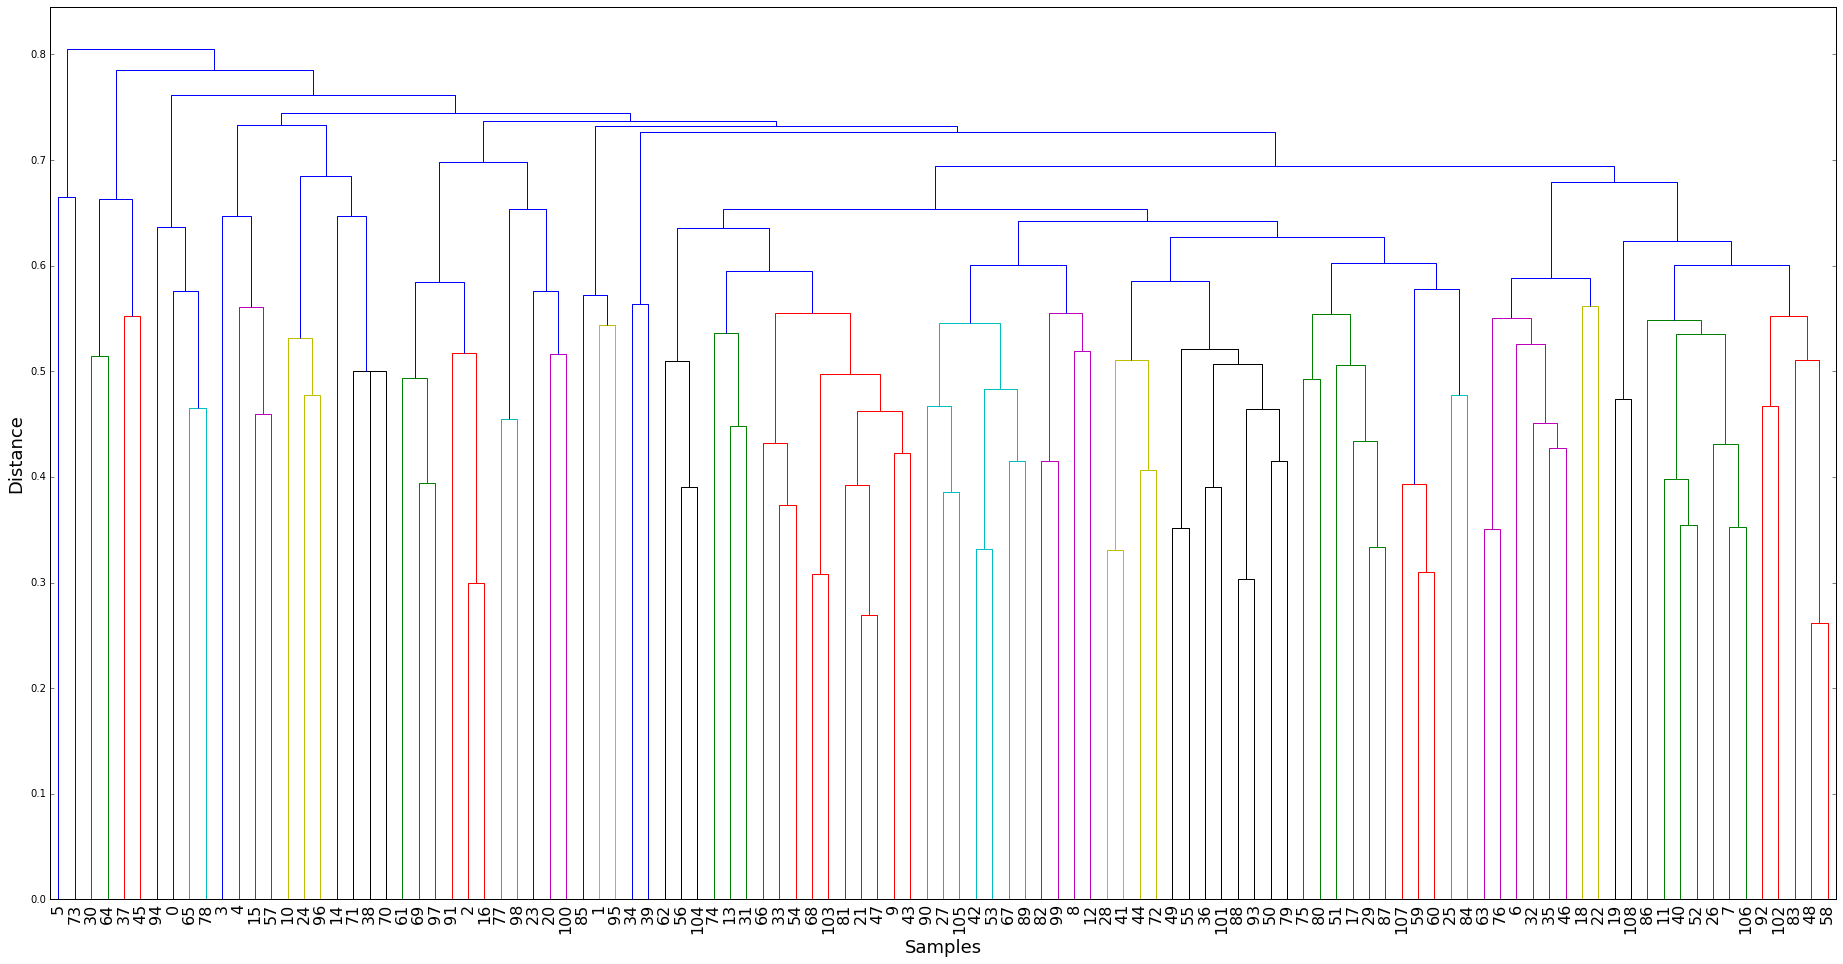

In [13]:
# This function gets pairwise distances between observations in n-dimensional space.
dists = pdist(data, metric="cosine")

# This scipy's function performs hierarchical/agglomerative clustering on the condensed distance matrix y.
links = linkage(dists, method='average')

# Now we want to plot those 'links' using "dendrogram" function
plt.rcParams['figure.figsize'] = 32, 16

den = dendrogram(links)

plt.xlabel('Samples',fontsize=18)
plt.ylabel('Distance',fontsize=18)
plt.xticks(rotation=90,fontsize=16)
plt.show()


We can use other measures:

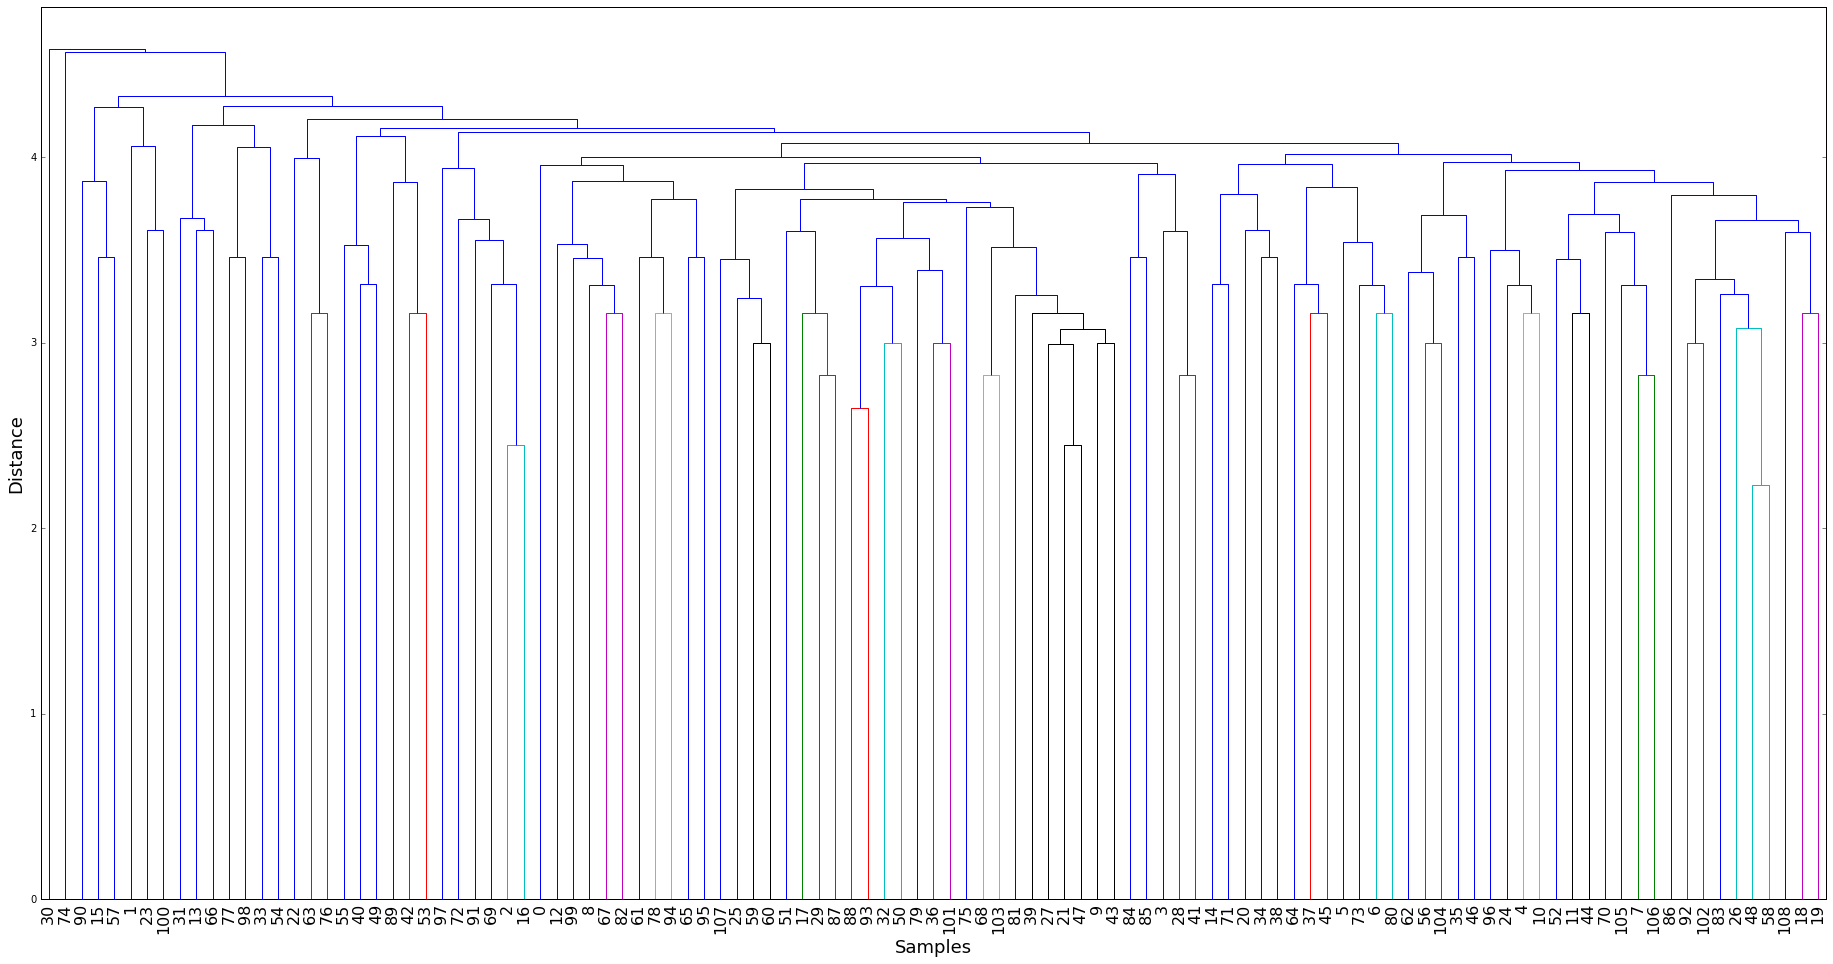

In [14]:
# This function gets pairwise distances between observations in n-dimensional space.
dists = pdist(data, metric="euclidean")

# This scipy's function performs hierarchical/agglomerative clustering on the condensed distance matrix y.
links = linkage(dists, method='average')

# Now we want to plot those 'links' using "dendrogram" function
plt.rcParams['figure.figsize'] = 32, 16

den = dendrogram(links)

plt.xlabel('Samples',fontsize=18)
plt.ylabel('Distance',fontsize=18)
plt.xticks(rotation=90,fontsize=16)
plt.show()


In [15]:
#data[74:75]
#data[1:2]
#data[30:31]
#data[108:109]
#print(np.where(data.index=='Bunnahabhain')[0])
#data[18:19]

It is common to cut dendrograms at a particular height and to then use the resulting clusters. 

<img src="images/clustering.png" height=90% width=90%>

[That's David Whishart who wrote a well-known book based on clustering whiskeys.]

## KMeans

Another method for finding clusters is to use the KMeans algorithm to find a set of $k$ clusters. Here, unlike in hierarchical clustering, we define the number of clusters in advance. We'll use the library **sklearn.cluster**

Here is a nice illustrated example: http://util.io/k-means  (but it looks like the interactivity is broken)

In [16]:

k_clusters = 6

## Fit clusters like in our previous models/transformations/standarization 
## (e.g. Logistic, Vectorization,...)

model = KMeans(k_clusters)
model.fit(data)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

What clusters do we get? Let's get "predictions" of the model:


In [17]:
print ("Records in our dataset (rows): ", len(data.index))
print ("Then we predict one cluster per record, which means length of: ", len(model.predict(data)) )


Records in our dataset (rows):  109
Then we predict one cluster per record, which means length of:  109


In [18]:
data.index

Index(['Aberfeldy', 'Aberlour', 'Ardberg', 'Ardmore', 'Auchentoshan',
       'Aultmore', 'Balblair', 'Balmenach', 'Balvenie', 'Banff',
       ...
       'Strathisla', 'Talisker', 'Tamdhu', 'Tamnavulin', 'Teaninich',
       'Tobermory', 'Tomatin', 'Tomintoul', 'Tormore', 'Tullibardine'],
      dtype='object', length=109)

In [19]:
clusters = model.predict(data)

clusters

array([4, 1, 5, 3, 0, 0, 0, 4, 1, 4, 0, 2, 1, 5, 0, 0, 5, 3, 0, 2, 0, 4, 5,
       1, 0, 3, 2, 3, 3, 4, 1, 3, 3, 5, 2, 0, 5, 2, 0, 4, 2, 3, 1, 4, 2, 1,
       0, 4, 0, 2, 3, 5, 2, 0, 5, 2, 3, 0, 0, 4, 1, 1, 3, 0, 4, 1, 5, 1, 4,
       3, 0, 3, 5, 4, 3, 4, 0, 5, 3, 5, 4, 4, 1, 0, 1, 1, 2, 4, 5, 2, 1, 0,
       0, 5, 1, 1, 0, 2, 5, 1, 4, 5, 0, 4, 4, 4, 0, 4, 2], dtype=int32)

In [20]:
pd.DataFrame(list(zip(data.index,model.predict(data))), columns=['Whiskey','Cluster_predicted']) [0:10]

,Whiskey,Cluster_predicted
0,Aberfeldy,4
1,Aberlour,1
2,Ardberg,5
3,Ardmore,3
4,Auchentoshan,0
5,Aultmore,0
6,Balblair,0
7,Balmenach,4
8,Balvenie,1
9,Banff,4


Let's put each cluster into its own column!


In [21]:

cluster_listing = {}
for cluster in range(k_clusters):
    cluster_listing['Cluster ' + str(cluster)] = [''] * 109
    where_in_cluster = np.where(clusters == cluster)[0]
    cluster_listing['Cluster ' + str(cluster)][0:len(where_in_cluster)] = data.index[where_in_cluster]

# Print clusters
pd.DataFrame(cluster_listing).loc[0:np.max(np.bincount(clusters)) - 1,:]


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
0,Auchentoshan,Aberlour,Benriach,Ardmore,Aberfeldy,Ardberg
1,Aultmore,Balvenie,Bunnahabhain,Brackla,Balmenach,Benromach
2,Balblair,Benrinnes,Cragganmore,Convalmore,Banff,Bowmore
3,Ben Nevis,Clynelish,Edradour,Craigellachie,Caperdonich,Cardhu
4,Bladnoch,Dalmore,Glenallachie,Dailuaine,Dallas Dhu,Dufftown
5,Blair Athol,Glendullan,Glen Deveron,Dalwhinnie,Glencadam,Glen Albyn
6,Bruichladdich,Glenfarclas,Glenesk,Deanston,Glen Elgin,Glen Keith
7,Caol Ila,Glenrothes,Glengoyne,Glendronach,Glen Garioch,Glenlochy
8,Coleburn,Glen Scotia,Glenkinchie,Glen Grant,Glen Ordie,Glenury Royal
9,Fettercairn,Glenugie,Glenlossie,Glen Mhor,Glenturret,Jura


How can we name or describe these clusters? 

[That's a question for you!]

-


-


-


-


-


-


-


-


-


-


Let's take a look at the results of a particular clustering from Lapointe and Legendre's *A Classification of Pure Malt Scotch Whiskies*. In this clustering, they create 12 clusters A through L. Let's take cluster J as an example and built a decision tree that will classifier all whiskies as either belonging to J or not belonging to J.

<img src="images/cluster_tree.png" height=50% width=50%>

Ok.

Now just for illustration, let's take a look at a different data set, that only has two features. This will make visualizing what's going on much easier.

In [22]:
## This function returns 2 columns of data and the Y-target

X, Y = data_tools.make_cluster_data()


In [23]:
pd.DataFrame(X).head()

,0,1
0,9.017511,0.570328
1,-11.551072,0.047874
2,-5.292157,3.845912
3,-9.530848,1.406268
4,12.246895,-3.052619


Before using the target Y, let's plot the data and take a look.

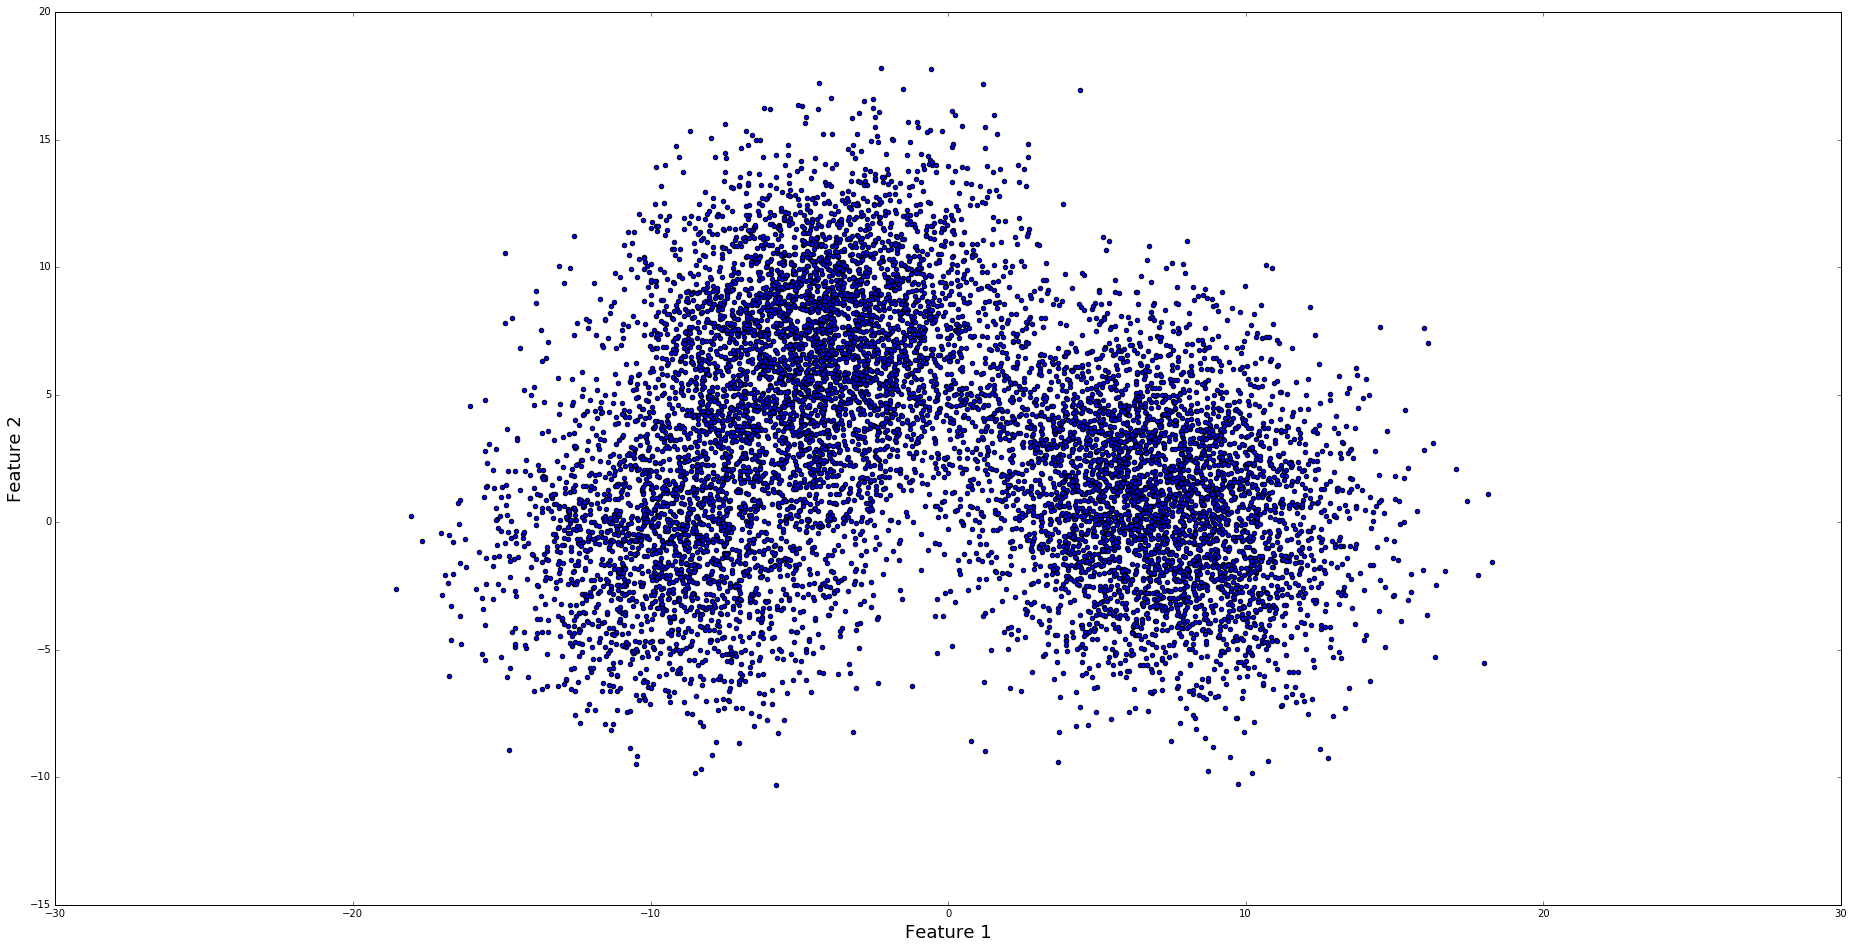

In [24]:
plt.scatter(X[:,0], X[:, 1], s=20)
plt.xlabel("Feature 1",fontsize=18)
plt.ylabel("Feature 2",fontsize=18)
plt.show()

Similar to what we did above, we can apply **KMeans** to this data. Let's try a few different values for the number of clusters $k$.

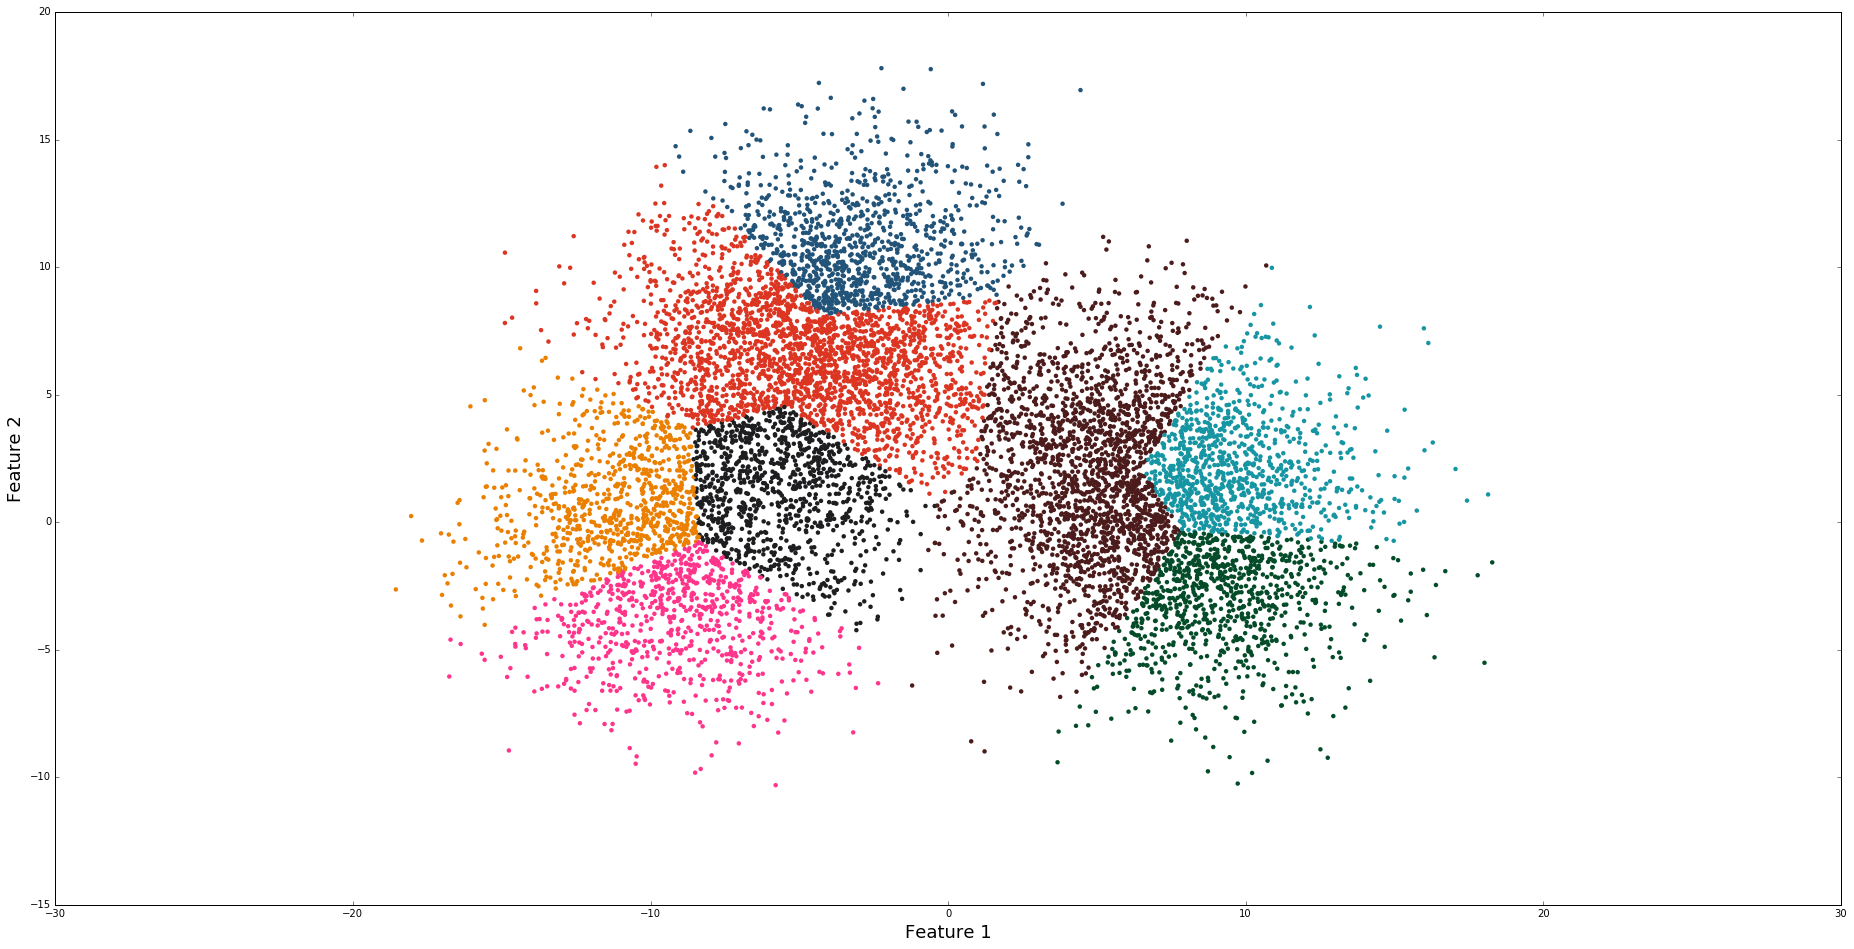

In [25]:
# KMeans
model = KMeans(10)
model.fit(X)

# Predict clusters
clusters = model.predict(X)

# Plot the same points but set two different colors (based on the cluster's results)

plt.scatter(X[:,0], X[:, 1], color=data_tools.colorizer(clusters), linewidth=0, s=20)
plt.xlabel("Feature 1",fontsize=18)
plt.ylabel("Feature 2",fontsize=18)
plt.show()


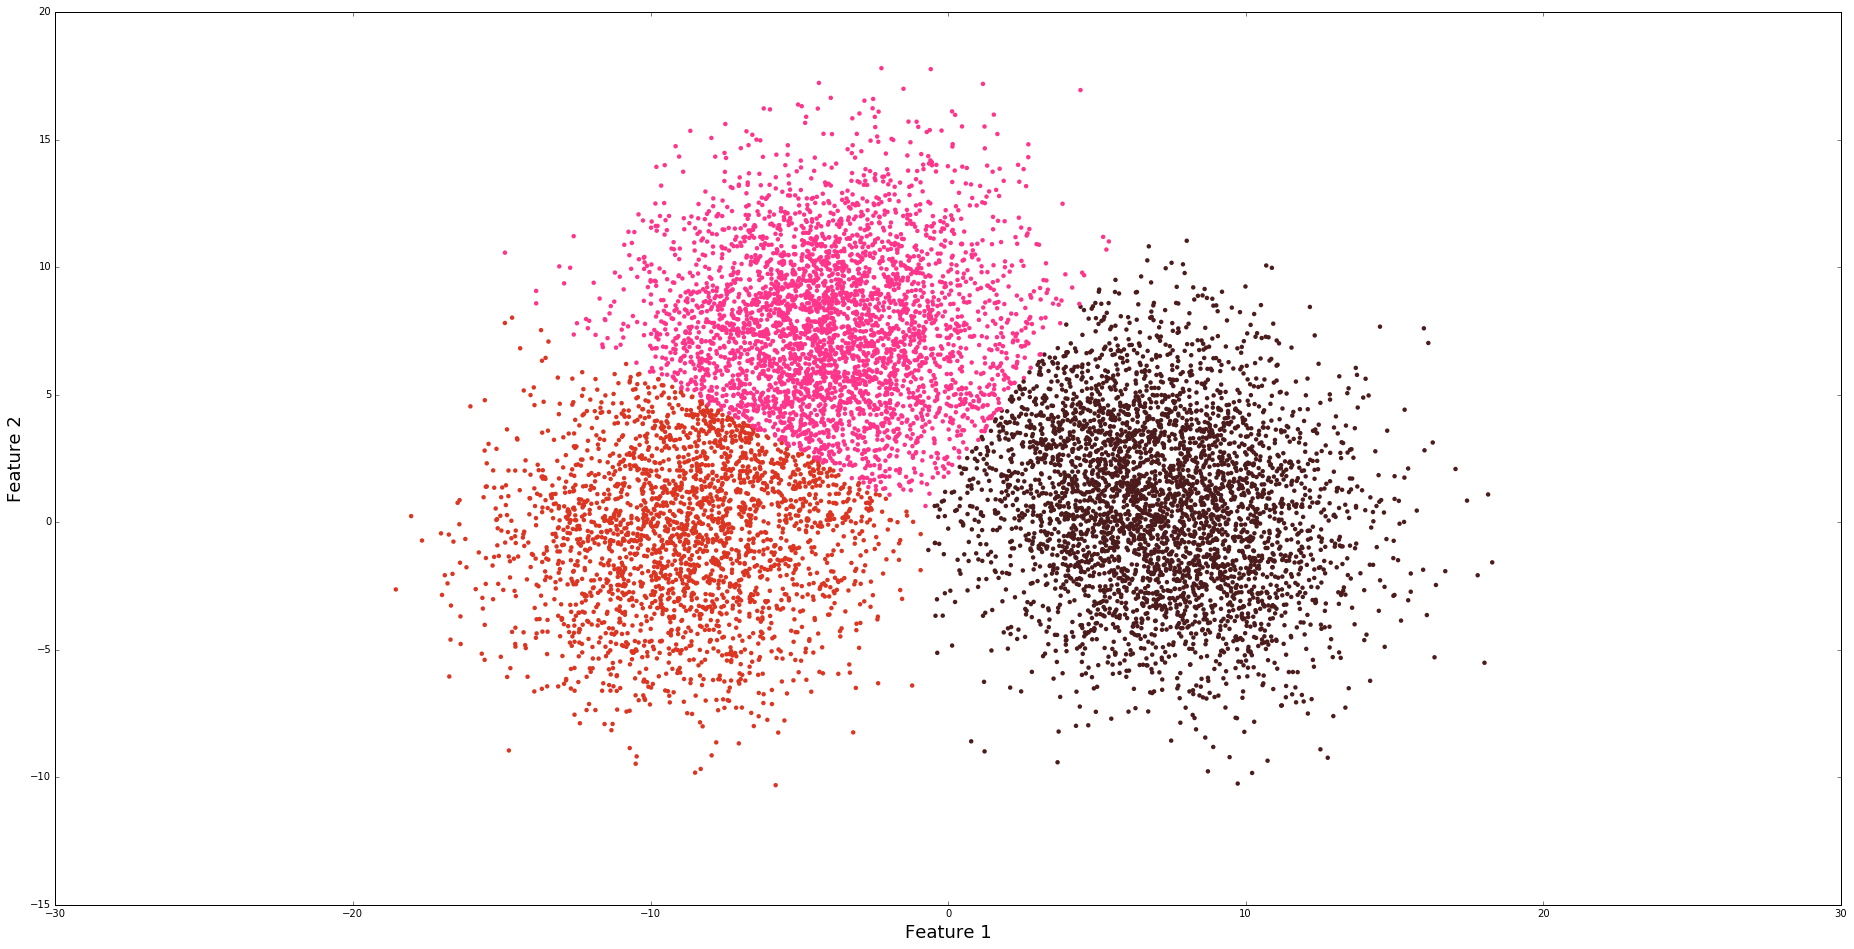

In [26]:
# KMeans
model = KMeans(3)
model.fit(X)

# Predict clusters
clusters = model.predict(X)

# Plot the same points but now set 3 different colors (based on the cluster's results)

plt.scatter(X[:,0], X[:, 1], color=data_tools.colorizer(clusters), linewidth=0, s=20)
plt.xlabel("Feature 1",fontsize=18)
plt.ylabel("Feature 2",fontsize=18)
plt.show()


## Prediction via Similarity

Now, what if we have a target variable to estimate/predict and labels for a training set?  We can do prediction directly using similarity.

For example, in this 2 dimensional data that we're using, we have five numerical **labels, 0 through 4**. One way to use similarity to build a predictor<sup>&dagger;</sup> is to use a **Nearest Neighbor algorithm**.  The idea is: to predict the value of the target variable for a data item, first find the most similary (closest) training data items.  The **k-Nearest-Neighbor** or **kNN** algorithm chooses the closest `k` data points.  Then, gather the values of the target variable for them, and then combine them somehow.  So, to classify, one might combine them by having them vote their classes.  (How would you combine to compute probability estimates?  How would you combine for a regression problem?)

<sup>&dagger;</sup>There's an interesting question as to whether we're actually building a *model* here.

Let's start by splitting our X and Y data into train and test sets.

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.75)

pd.DataFrame( list(zip(X[:,0],X[:, 1],Y_train)), columns=['Feature1','Feature2','Target']) [0:15]

//anaconda/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


,Feature1,Feature2,Target
0,9.017511,0.570328,2
1,-11.551072,0.047874,2
2,-5.292157,3.845912,1
3,-9.530848,1.406268,1
4,12.246895,-3.052619,0
5,-18.558400,-2.636974,1
6,-6.319102,7.440000,1
7,-2.497521,6.915478,0
8,-5.369056,7.603824,0
9,-8.516592,10.649839,0


Let's so our scatter plot with the true labels first. This is another option to plot different colors, using pylab!!

[Other maps of colors here..](http://matplotlib.org/examples/color/colormaps_reference.html)


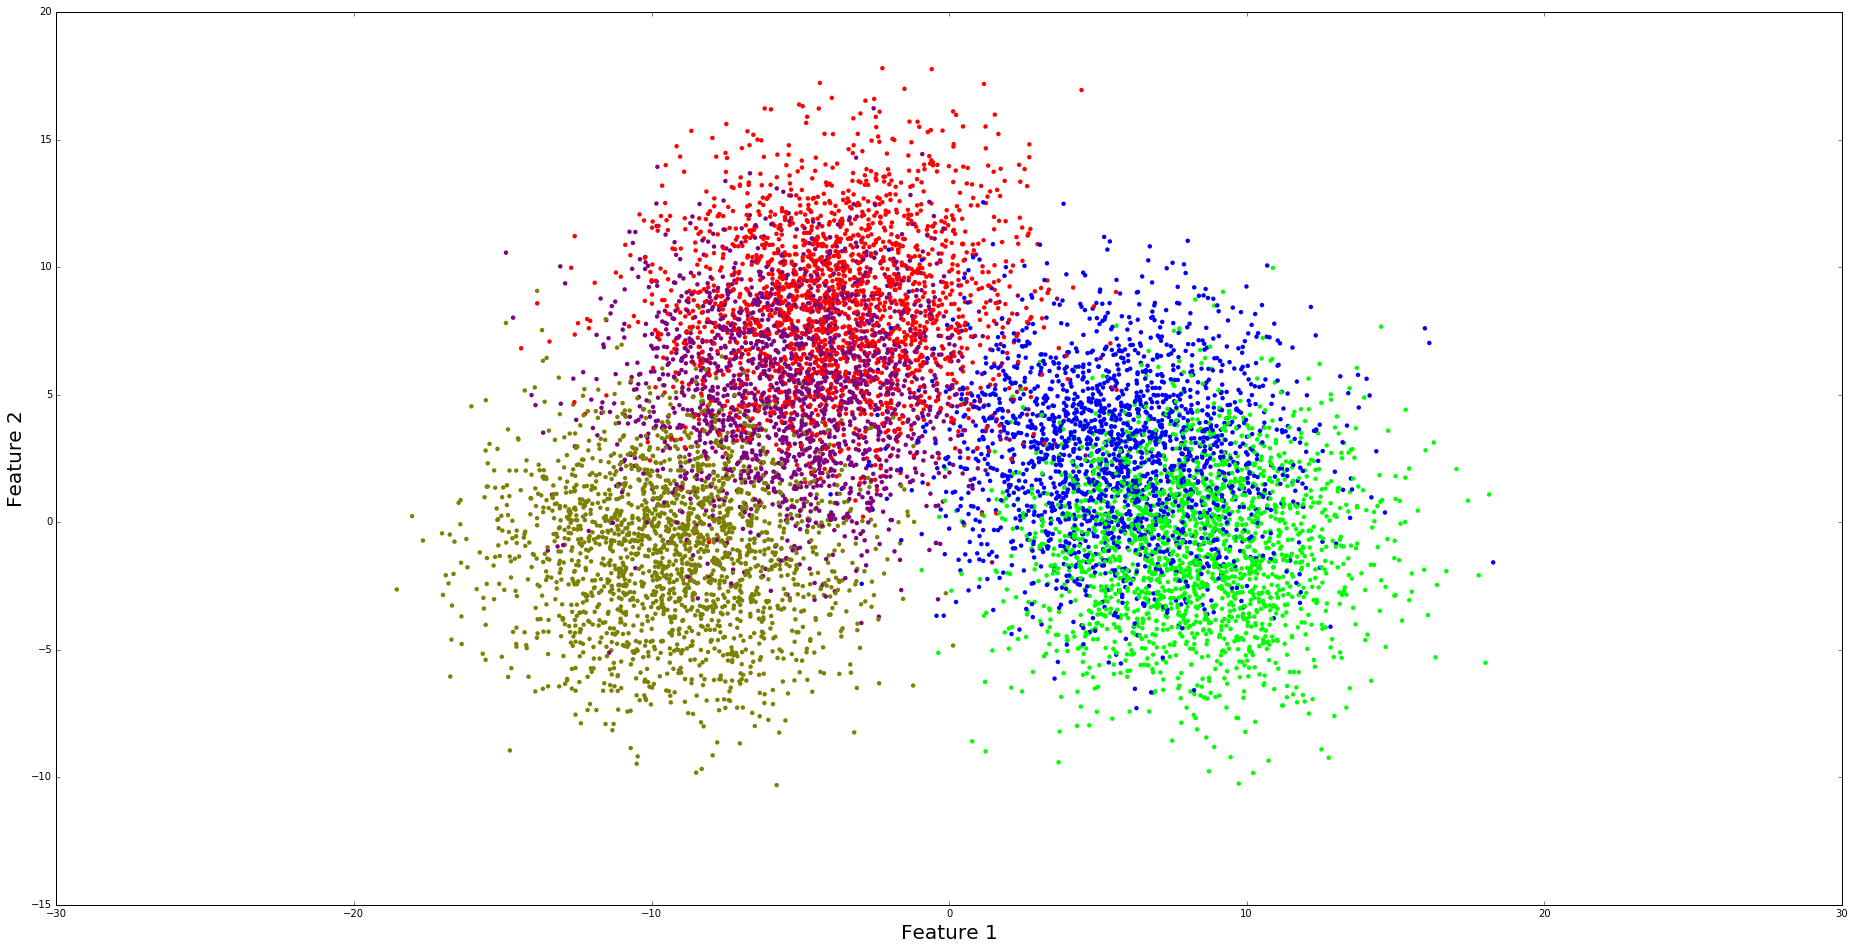

In [39]:

import pylab

plt.scatter( X[:,0], X[:, 1], c = Y, linewidth=0, s=20, cmap = pylab.cm.brg )
plt.xlabel("Feature 1",fontsize=20)
plt.ylabel("Feature 2",fontsize=20)
plt.show()


Now, let's try setting the number of neighbors to use, $k$, to a few different values and look at the results.

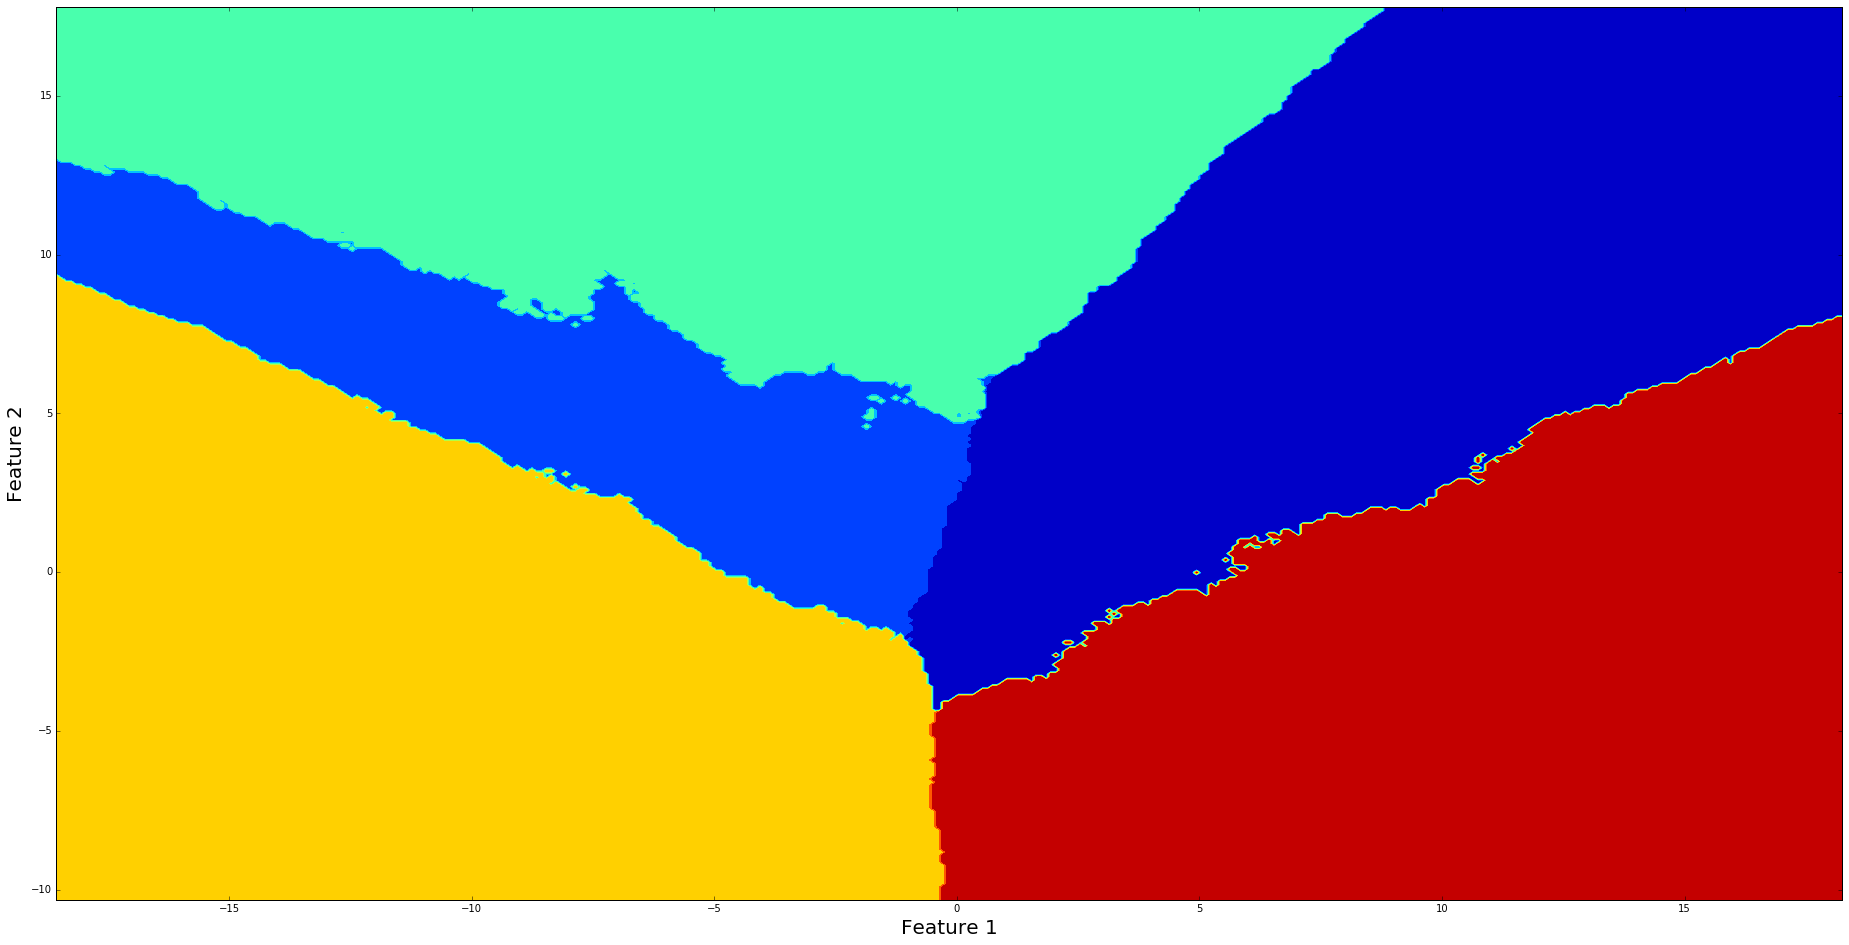

In [29]:

# KNN
model = KNeighborsClassifier(100)
model.fit(X_train, Y_train)
data_tools.Decision_Surface(X, Y, model, cell_size=.1, surface=True, points=False)


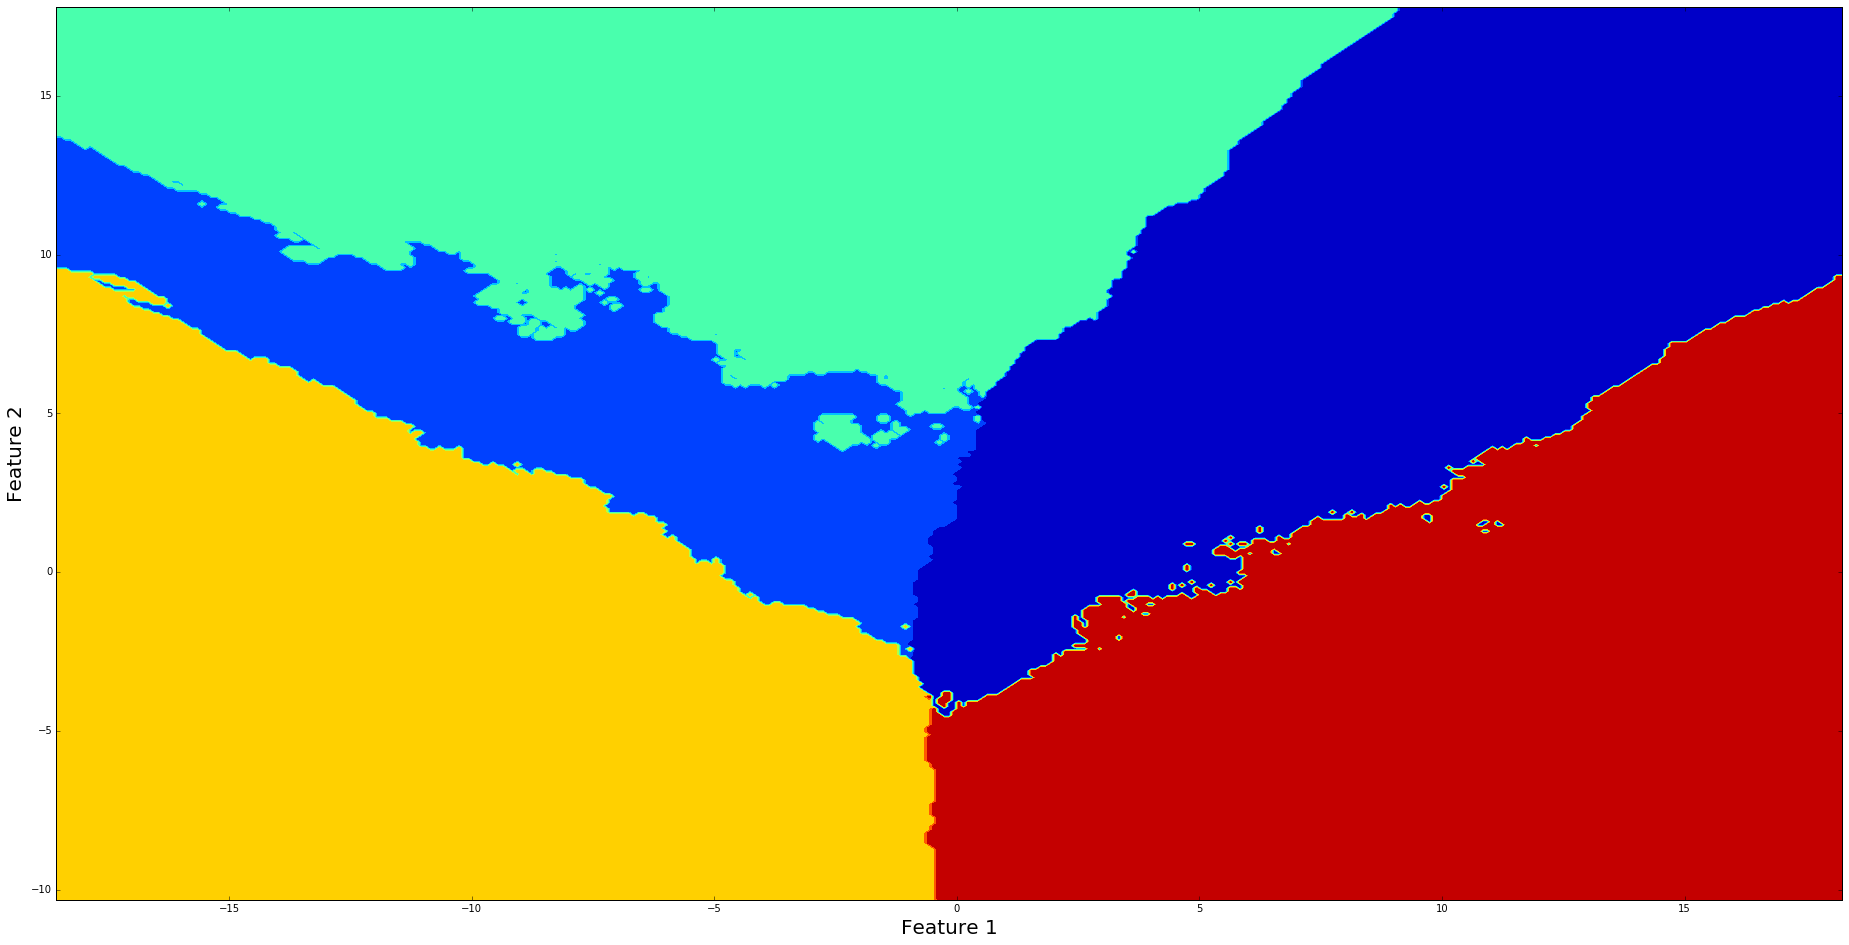

In [30]:

# KNN
model = KNeighborsClassifier(50)
model.fit(X_train, Y_train)
data_tools.Decision_Surface(X, Y, model, cell_size=.1, surface=True, points=False)


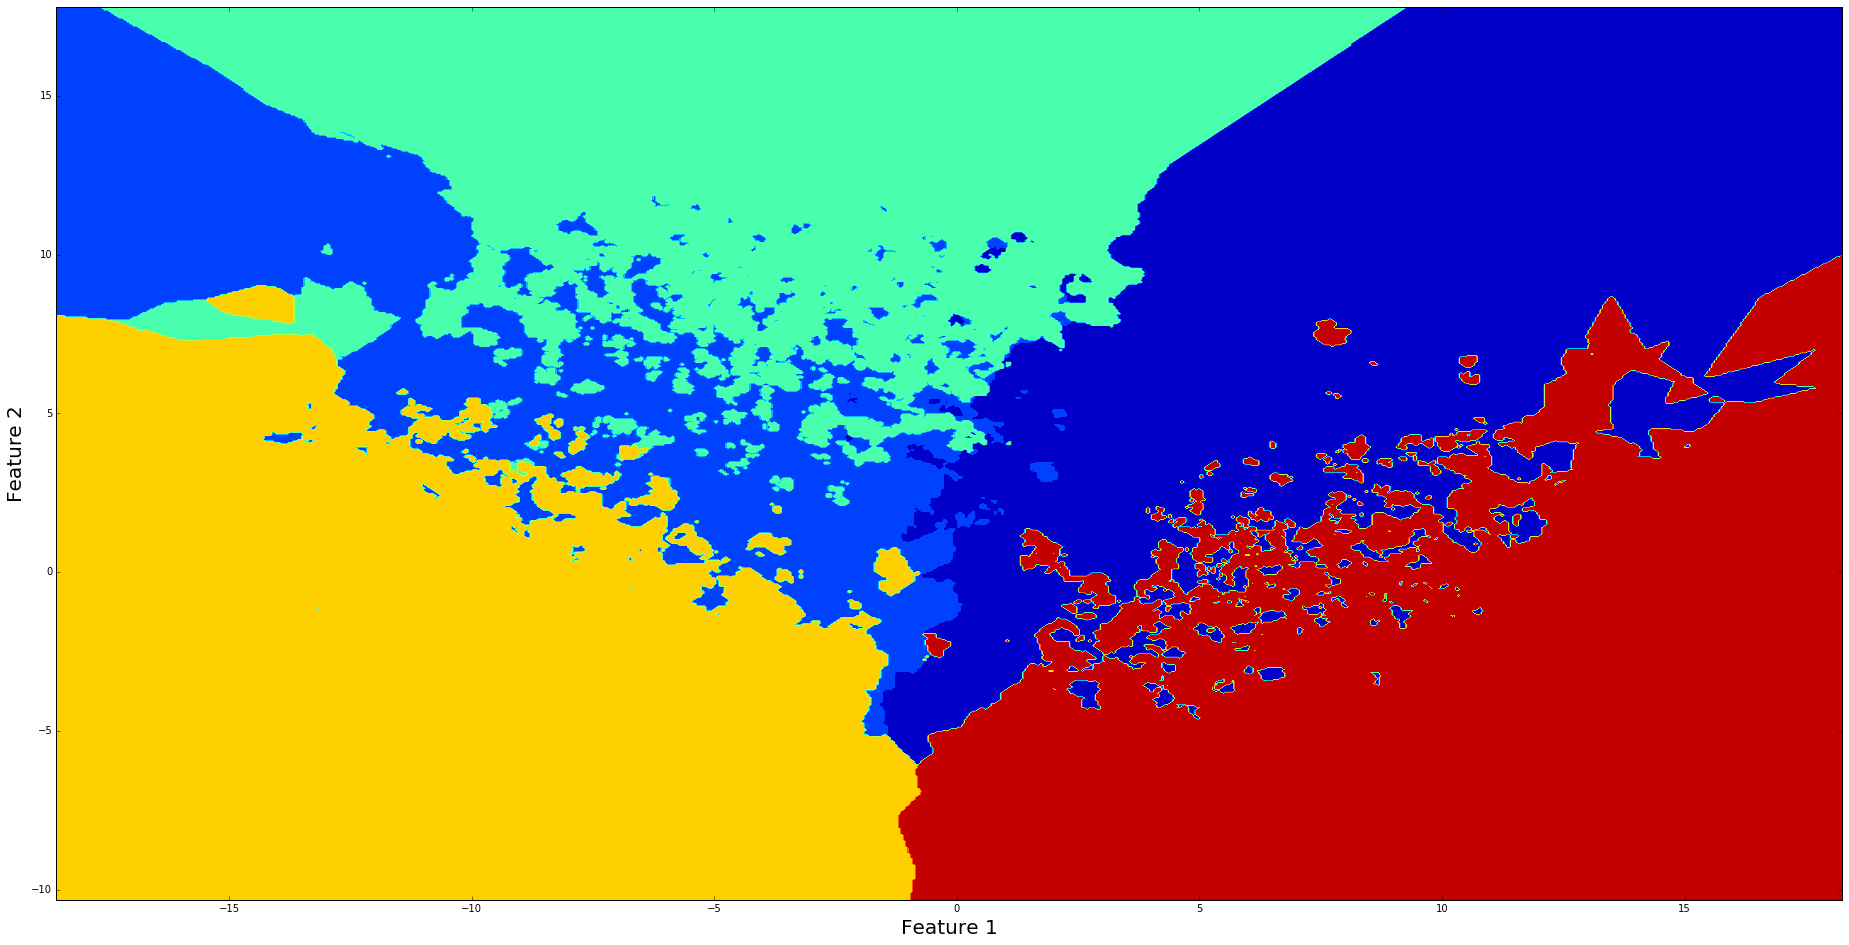

In [31]:

# KNN
model = KNeighborsClassifier(5)
model.fit(X_train, Y_train)
data_tools.Decision_Surface(X, Y, model, cell_size=.05, surface=True, points=False)


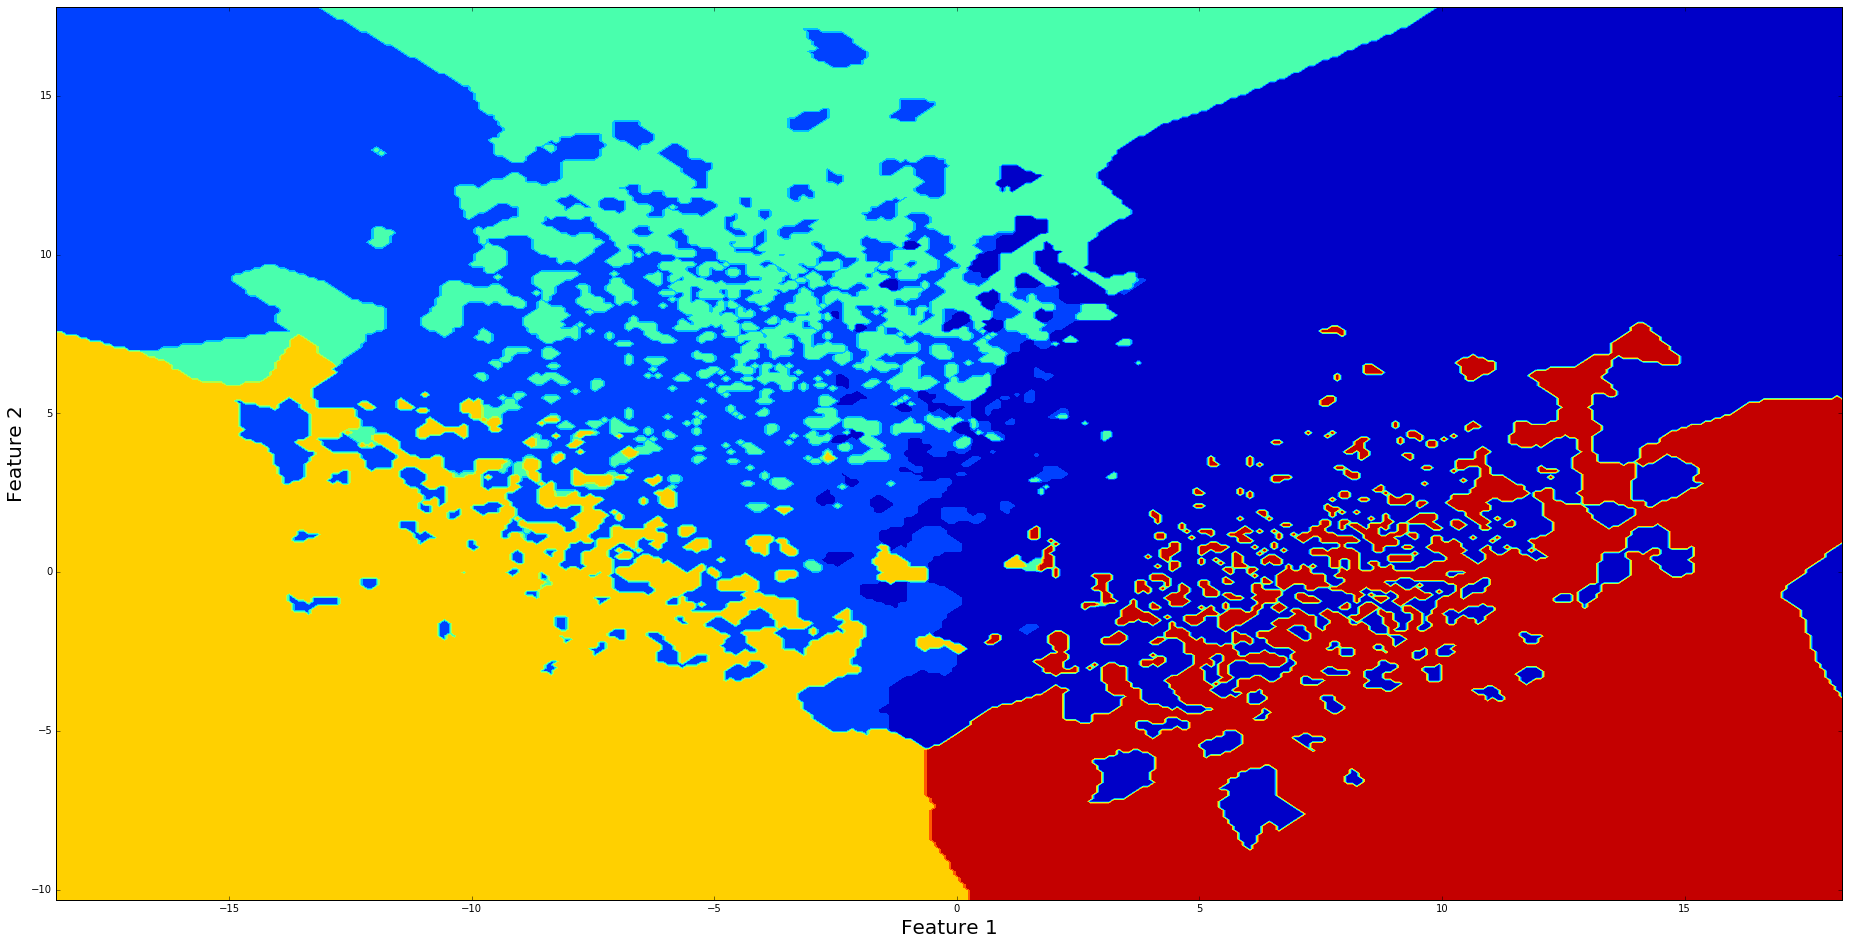

In [32]:

# KNN
model = KNeighborsClassifier(2)
model.fit(X_train, Y_train)
data_tools.Decision_Surface(X, Y, model, cell_size=.1, surface=True, points=False)


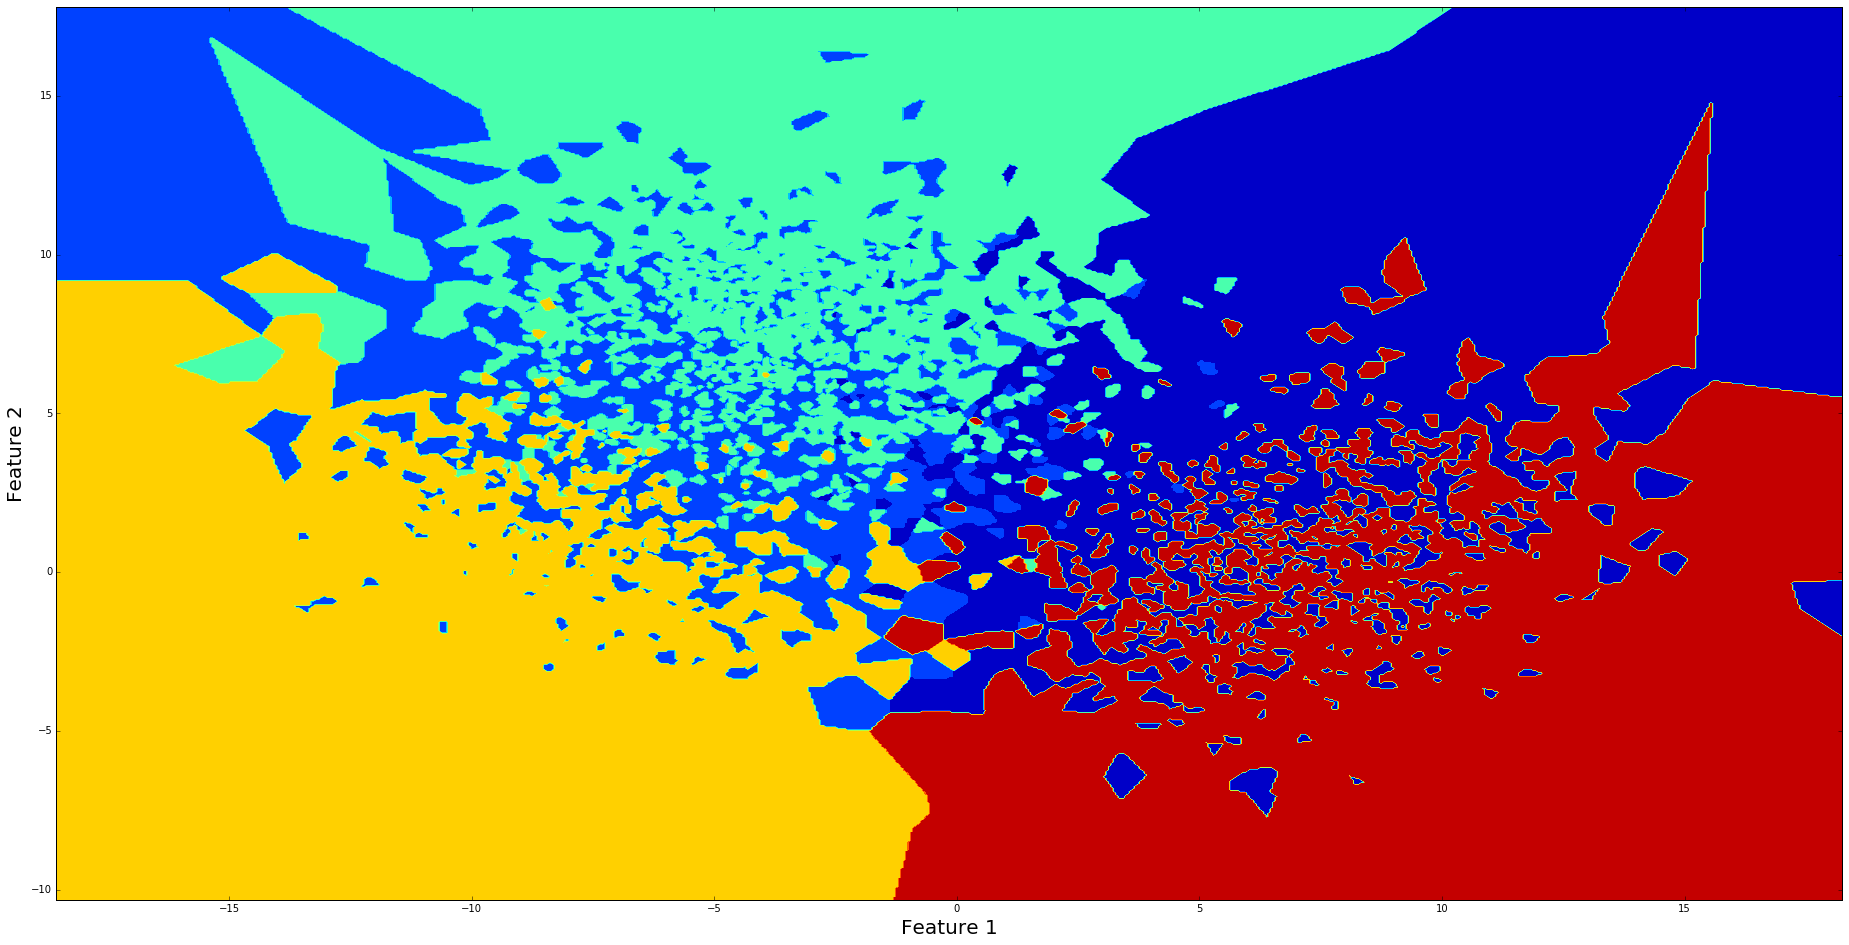

In [33]:

# KNN
model = KNeighborsClassifier(1)
model.fit(X_train, Y_train)
data_tools.Decision_Surface(X, Y, model, cell_size=.05, surface=True, points=False)


You can see that as we make $k$ smaller, we get many smaller blobs all bunched together. What happens when we get down to $k=1$?

Even though we have 5 classes, we can still use the evaluation metrics we have already learned about. Accuracy should be straightforward:

In [34]:

for k in [1, 10, 50, 100, 1000, 2000]:
    model = KNeighborsClassifier(k)
    model.fit(X_train, Y_train)
    print ("Accuracy with k = %d is %.3f" % (k, metrics.accuracy_score(Y_test, model.predict(X_test))) )
    

Accuracy with k = 1 is 0.630
Accuracy with k = 10 is 0.698
Accuracy with k = 50 is 0.712
Accuracy with k = 100 is 0.717
Accuracy with k = 1000 is 0.720
Accuracy with k = 2000 is 0.718


We can also look at AUC; we can do this evaluating each label (0 to 4) versus the rest.

In [35]:
ks = [1, 5, 10, 50, 100, 500, 1000, 2000]
avg_aucs = []
aucs_dict = {}
for k in ks:
    
    model = KNeighborsClassifier(k)
    model.fit(X_train, Y_train)
    probabilities = model.predict_proba(X_test)
    
    
    print("KNN with k = %d" % k)
    aucs = 0
    for i in range(5):
        auc = metrics.roc_auc_score(Y_test == i, probabilities[:,i])
        aucs += auc
        
        if k == ks[0]:
                aucs_dict[i] = []
        aucs_dict[i].append(auc)
        print("   AUC for label %d vs. rest = %.3f" % (i, auc))
        
    avg_auc = aucs/5.0
    avg_aucs.append(avg_auc)
    print("   Average AUC = %.3f\n" % (avg_auc))

KNN with k = 1
   AUC for label 0 vs. rest = 0.765
   AUC for label 1 vs. rest = 0.661
   AUC for label 2 vs. rest = 0.734
   AUC for label 3 vs. rest = 0.890
   AUC for label 4 vs. rest = 0.798
   Average AUC = 0.770

KNN with k = 5
   AUC for label 0 vs. rest = 0.895
   AUC for label 1 vs. rest = 0.821
   AUC for label 2 vs. rest = 0.883
   AUC for label 3 vs. rest = 0.959
   AUC for label 4 vs. rest = 0.924
   Average AUC = 0.896

KNN with k = 10
   AUC for label 0 vs. rest = 0.916
   AUC for label 1 vs. rest = 0.866
   AUC for label 2 vs. rest = 0.916
   AUC for label 3 vs. rest = 0.973
   AUC for label 4 vs. rest = 0.942
   Average AUC = 0.923

KNN with k = 50
   AUC for label 0 vs. rest = 0.929
   AUC for label 1 vs. rest = 0.888
   AUC for label 2 vs. rest = 0.935
   AUC for label 3 vs. rest = 0.985
   AUC for label 4 vs. rest = 0.956
   Average AUC = 0.939

KNN with k = 100
   AUC for label 0 vs. rest = 0.931
   AUC for label 1 vs. rest = 0.891
   AUC for label 2 vs. rest = 0.9

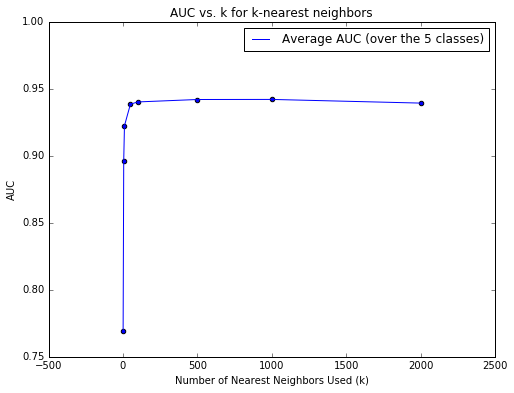

In [40]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
# for i in range(5):
#     plt.plot(ks,aucs_dict[i],marker='o', label = 'class {i}'.format(i=i))

plt.scatter(ks,avg_aucs, marker='o')
plt.plot(ks,avg_aucs, label = "Average AUC (over the 5 classes)")
plt.title("AUC vs. k for k-nearest neighbors")
plt.xlabel('Number of Nearest Neighbors Used (k)')
plt.ylabel('AUC')
plt.legend(loc='best')
plt.show()

This makes sense since the data we looked at was already linearly seperable. What if we use the non-linear Iris dataset?

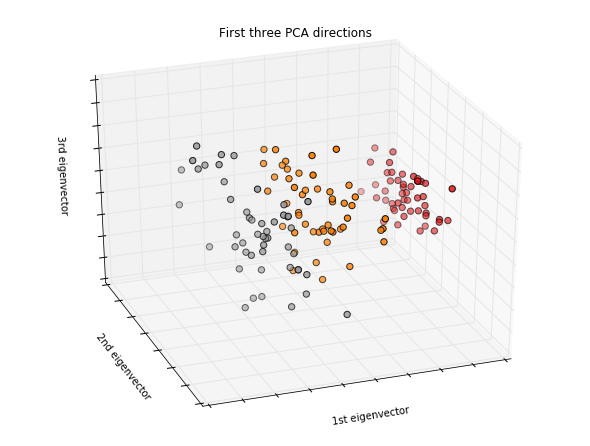

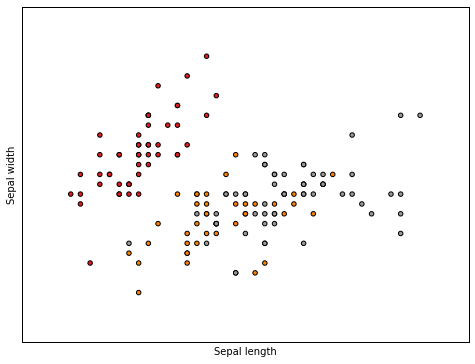

In [48]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

//anaconda/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


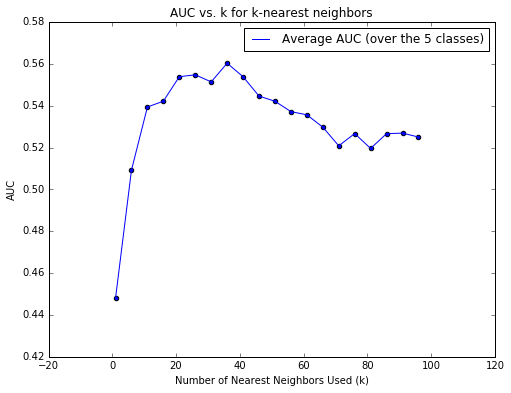

In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.75)

ks = range(1,100,5)
avg_aucs = []
aucs_dict = {}
for k in ks:
    
    model = KNeighborsClassifier(k)
    model.fit(X_train, Y_train)
    probabilities = model.predict_proba(X_test)
    
    
    aucs = 0
    for i in range(3):
        auc = metrics.roc_auc_score(Y_test == i, probabilities[:,i])
        aucs += auc
        
        if k == ks[0]:
                aucs_dict[i] = []
        aucs_dict[i].append(auc)
        
    avg_auc = aucs/5.0
    avg_aucs.append(avg_auc)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
# for i in range(5):
#     plt.plot(ks,aucs_dict[i],marker='o', label = 'class {i}'.format(i=i))

plt.scatter(ks,avg_aucs, marker='o')
plt.plot(ks,avg_aucs, label = "Average AUC (over the 5 classes)")
plt.title("AUC vs. k for k-nearest neighbors")
plt.xlabel('Number of Nearest Neighbors Used (k)')
plt.ylabel('AUC')
plt.legend(loc='best')
plt.show()

## Not in your notebooks - write down if you want to remember
### When to use KNN?
- Less than 20 attributes per instance
- Lots of training data (to be robust to noise)
### Advantages
- **Training is very fast**
- Represent arbitrarily complex separation functions
### Disadvantanges
- **Slow to query**: need to calculate distance from each point every time
- Easily fooled by irrelevant attributes